In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint, solve_ivp
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (7,4)

Simulation de systèmes dynamiques non lisses
==============================


Le cours se focalise sur l'étude de systèmes dynamiques réguliers, c'est-à-dire $\dot{x}=f(x)$ avec $f$ au moins continue, et le plus souvent continûment différentiable. Le but de ce projet est de découvrir des systèmes moins réguliers, dits *non-lisses*. Il existe une myriade de modélisations de ces systèmes mais on peut distinguer différents *niveaux* d'irrégularité:

 - $f$ est continue mais non différentiable en certains points (on parle de *nonsmooth dynamics of type 1*, i.e., *NSD1*) : cela peut arriver dans la modélisation d'écoulements par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ restent $C^1$ mais leur simulation peut déjà se compliquer.

 - $f$ est discontinue en certains points, ou le long de certaines surfaces (on parle de *NSD2*) : ceci apparaît typiquement en mécanique lors de la modélisation de contacts et friction entre solides, ou dans la modélisation de circuits électriques contenant des diodes par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ sont toujours (absolument) continues mais non différentiables, le schéma numérique doit détecter des changements de *mode*.

 - les solutions $t\mapsto x(t)$ sont elles-mêmes discontinues, présentant des *sauts*  à certains instants ou lorsqu'elles rencontrent certaines surfaces, et il faut ajouter à $f$ un modèle de ces sauts (on parle de *NSD3*) : ceci apparaît typiquement avec les systèmes mécaniques à impact.

L'étude mathématique de ces sytèmes est très complexe, faisant appel à des outils qui nous mèneraient trop loin de ce cours (inclusions différentielles, complémentarité, analyse convexe, *measure differential inclusions*, etc), notre but est seulement d'en découvrir certains aspects à travers des exemples iconiques. Les curieux peuvent se référer à la documentation fournie par 

https://www.inria.fr/en/modelling-mechanics-simulation-fibres

https://www.inria.fr/en/tripop

ou aux ouvrages de références tels que

https://link.springer.com/book/10.1007/978-94-015-7793-9

https://link.springer.com/book/10.1007/978-3-540-44398-8 




## Dynamique non différentiable (NSD1)

Reprenons la loi de Toriccelli étudiée en TD et modélisant (modulo reparamétrisation) l'écoulement d'un fluide dans un réservoir
$$
\dot{x} = - \sqrt{|x|} \tag{1}
$$

**Question 1** Coder un schéma Euler explicite permettant de simuler une équation différentielle $\dot{x}=f(x,t)$ à partir d'une condition initiale $x_0$ au temps $t_0$ jusqu'au temps $t_f$ avec un pas de temps $dt$. 

In [2]:
def f(x,t):
    return -np.sqrt(np.abs(x))
    
def euler_explicit(f, x0, t0, tf, dt):
    t = np.arange(t0, tf + dt, dt)
    x = np.zeros(len(t))
    x[0] = x0
    for i in range(len(t) - 1):
        x[i+1] = x[i] + dt * f(x[i], t[i])
    return t, x

**Question 2** L'utiliser pour simuler un écoulement d'une hauteur initiale $x_0=10$ pendant 10 unités de temps. Tracer la solution obtenue. Est-elle celle que l'on attend ? Les solver ''odeint'' ou ''solve_ivp" de scipy fait-il mieux ? Expliquer pourquoi. Proposer une façon de simuler *la* solution *physique*.



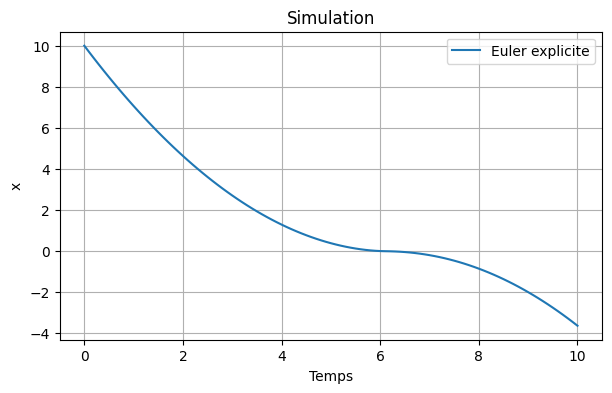

In [3]:
x0 = 10
t0 = 0
tf = 10
dt = 0.1

#graphique
t, x = euler_explicit(f,x0,t0,tf,dt)

plt.figure()
plt.plot(t, x, label='Euler explicite')
plt.title('Simulation')
plt.xlabel('Temps')
plt.ylabel('x')
plt.grid()
plt.legend()
plt.show()

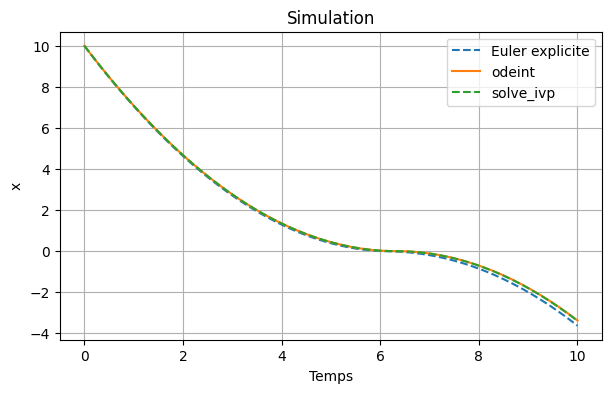

In [4]:
t_scipy = np.linspace(t0, tf, 100)
x_odeint = odeint(f, x0, t_scipy)

def f_ivp(t, x): 
    return f(x, t)
    
res_ivp = solve_ivp(f_ivp, [t0, tf], [x0], t_eval=t_scipy)

#graphique
plt.figure()
plt.plot(t, x, label='Euler explicite', linestyle='--')
plt.plot(t_scipy, x_odeint, label='odeint')
plt.plot(res_ivp.t, res_ivp.y[0], label='solve_ivp',linestyle='--')

plt.title('Simulation')
plt.xlabel('Temps')
plt.ylabel('x')
plt.grid()
plt.legend()
plt.show()

En pratique, on essaye toujours de se ramener à une modélisation *bien posée* dont les solutions existent et sont uniques (ajout de contraintes ou régularisation, par exemple). Ici, on pourrait par exemple considérer plutôt
$$
\dot{x} = - {\rm sign}(x) \sqrt{|x|} \tag{2}
$$
avec ${\rm sign}(0)$ arbitraire. 

**Question 3** Montrer que pour toute condition initiale dans $\mathbb{R}$, (2) admet une unique solution maximale en temps positif définie sur $\mathbb{R}_{\geq 0}$, et qu'elle correspond à la solution ``physique'' attendue précédemment pour des conditions initiales positives. Justifier que l'on parle de "convergence globale vers 0 en temps fini". Illustrer ce phénomène en simulation. Ce comportement serait-il possible pour $\dot{x}=f(x)$ avec $f$ continûment différentiable ?


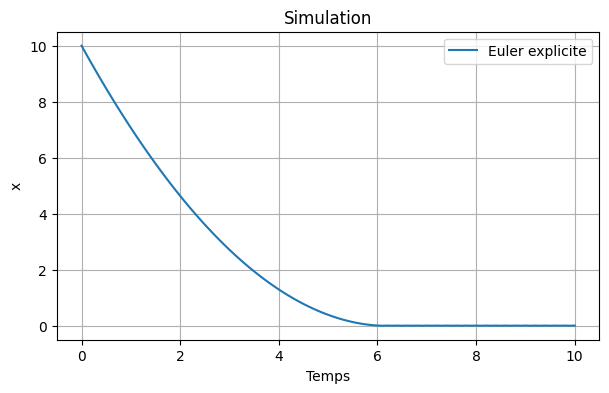

In [5]:
# "convergence globale en temps fini vers 0" : globale car quelque soit x0, la solution rejoint l'origine
# et temps fini car contrairement aux systèmes linéaires où l'on atteint la limite 0 qu'à l'asymptote, ici x = 0 est atteint pour un temps fini.

def f_avec_signe(x,t):
    return -np.sign(x)*np.sqrt(np.abs(x))

#graphique
x0 = 10
t0 = 0
tf = 10
dt = 0.1

t, x = euler_explicit(f_avec_signe,x0,t0,tf,dt)

plt.figure()
plt.plot(t, x, label='Euler explicite')
plt.title('Simulation')
plt.xlabel('Temps')
plt.ylabel('x')
plt.grid()
plt.legend()
plt.show()

#Ce comportement ne sera pas possible ave f continûment différentiable car Cauchy-Lipschitz s'applique partout 
#et puisque f(0)=0, l'unique solution passant par x = 0 pour tout t est x(t)=0 pour tout t

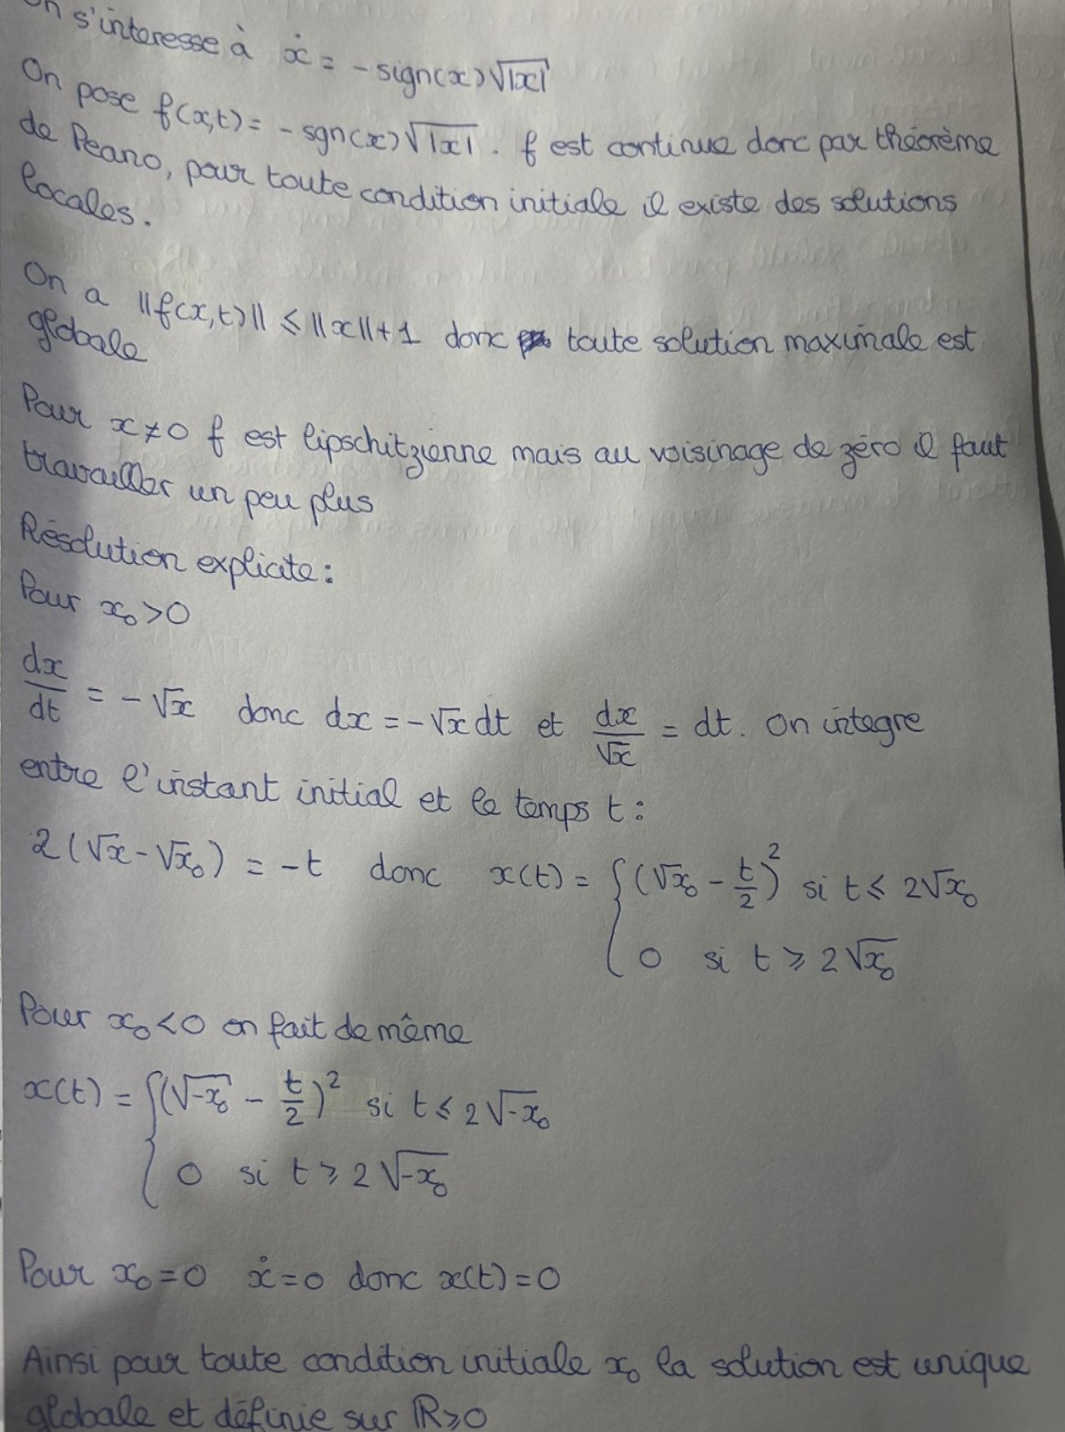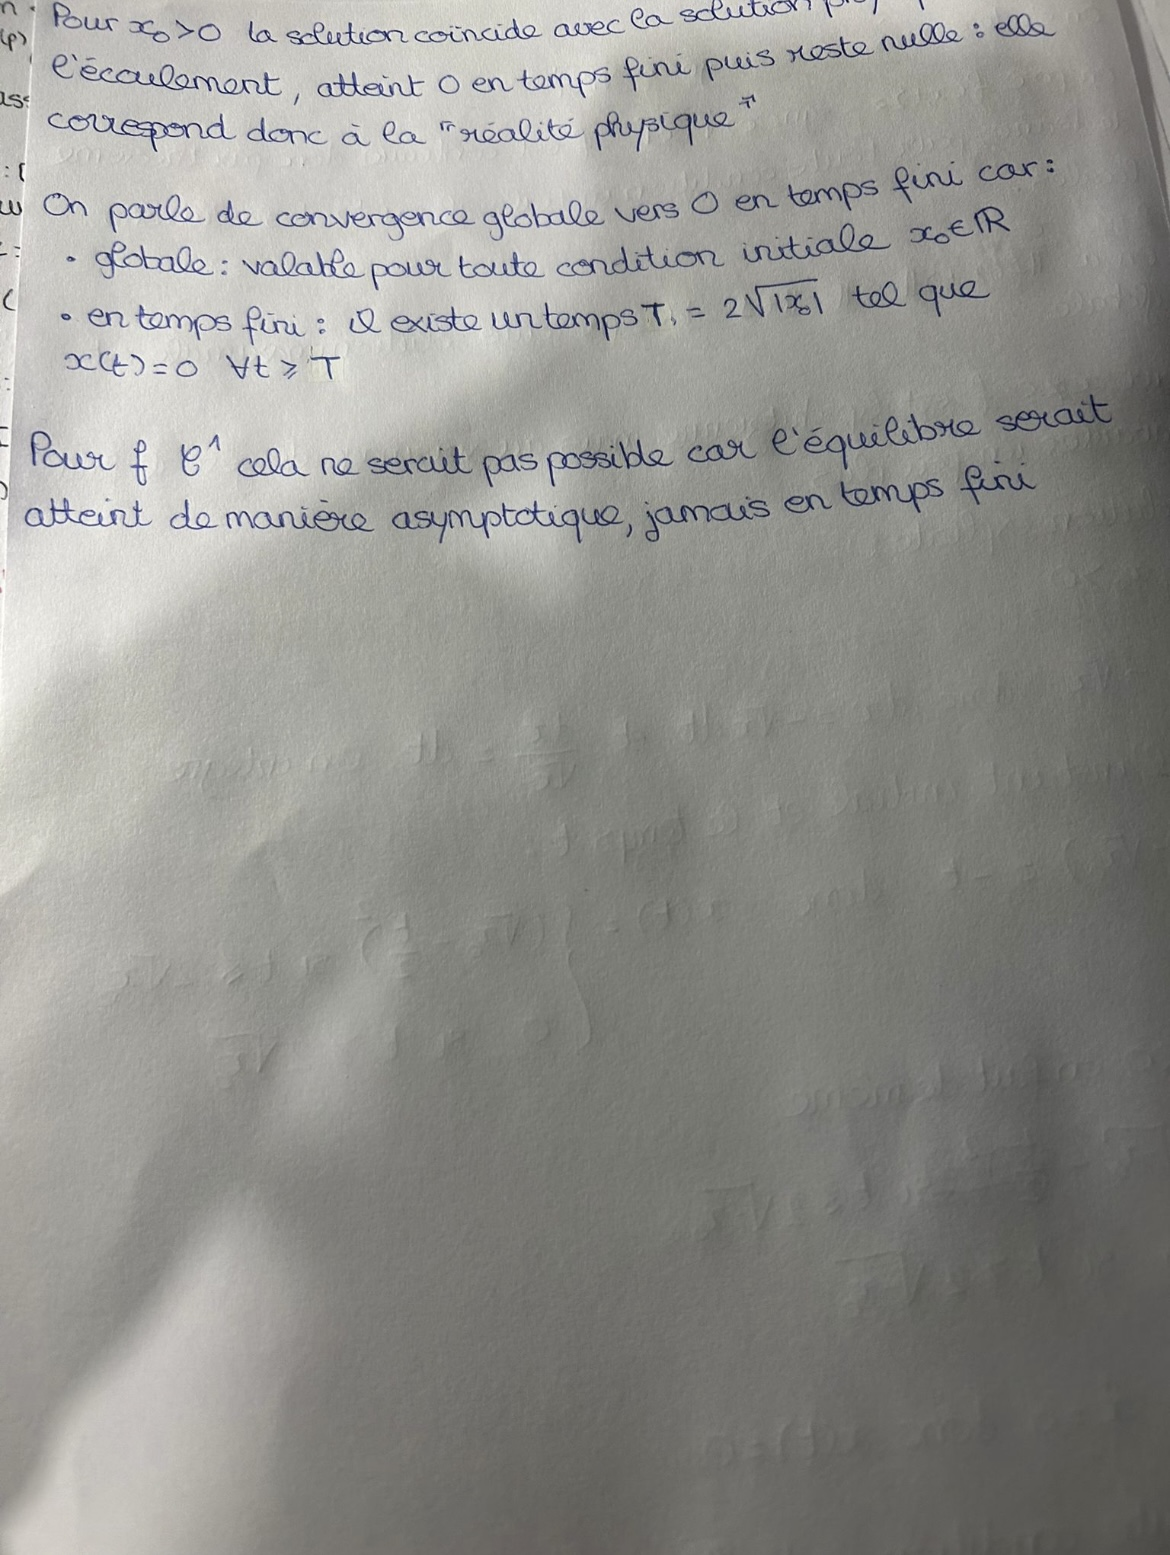

## Dynamique discontinue (NSD2)



Passons maintenant à une irrégularité plus forte, lorsque la fonction $f$ décrivant l'équation différentielle $\dot{x}=f(x)$ est discontinue, c'est-à-dire lorsque la solution $x$ suit des dynamiques différentes selon les régions de l'espace (par exemple selon le sens du courant pour des diodes, selon le sens de la vitesse pour des frottements secs etc.). Un exemple emblématique de ce cas de figure est 
$$
\dot{x} = - k {\rm sign}(x) \tag{3}
$$
pour $k>0$ et la valeur de ${\rm sign}(0)$ à définir.

**Question 4** Démontrer que pour une valeur de ${\rm sign}(0)$ bien choisie, (3) admet, pour toute condition initiale $x_0\in \mathbb{R}$, une unique solution maximale $t\mapsto x(t)$ en temps positif définie sur $\mathbb{R}_{\geq 0}$ et convergeant en temps fini vers 0. L'expliciter.


Considérons maintenant $\delta_m>0$ et l'équation différentielle perturbée
$$
\dot{x} = - k{\rm sign}(x) + \delta(t) \tag{4}
$$
pour $t\mapsto \delta(t)$ telle que $|\delta(t)|\leq \delta_m$ pour tout $t$.

**Question 5** Démontrer que si $k>\delta_m$, alors (4) admet toujours, pour toute condition initiale $x_0\in \mathbb{R}^*$ et quelle que soit la perturbation $\delta$ bornée par $\delta_m$, une unique solution maximale $t\mapsto x(t)$ en temps positif et convergeant en temps fini vers 0. Justifier que ces solutions pourraient être définie sur $\mathbb{R}_{\geq 0}$ si on acceptait que ${\rm sign}(0)$ puisse prendre n'importe quelle valeur entre -1 et 1.

Ceci mène en fait à la notion d'*inclusion différentielle* $\dot{x}\in f(x)$, où la fonction signe serait ici une fonction *multivaluée*, c'est-à-dire à valeurs ensembliste (*set-valued map*), définie par
$$
{\rm Sign}(x) = \left\{
\begin{array}{ll}
{1} & \text{si x>0} \\
[-1,1] & \text{si x=0} \\
-1 & \text{si x<0}
\end{array}
\right.
$$
Ce genre de phénomène est utilisé en commande ou estimation par *mode-glissant* (*sliding mode*) pour stabiliser des systèmes dynamiques en temps fini et malgré la présence de perturbations inconnues ou d'incertitudes dans le modèle. Le prix à payer pour ce genre de système est une grande sensibilité au bruit et une difficulté accrue de les discrétiser et simuler.

*Pour la culture* : La théorie des inclusions différentielles a été développée par Filippov, voir https://link.springer.com/book/10.1007/978-3-319-28664-8. Elle a montré que le ``bon'' cadre pour qu'une inclusion différentielle ait de bonnes propriétés (notamment que des approximations de solutions convergent vers des solutions, c'est-à-dire la compacité séquentielle des solutions, permettant la discrétisation et simulation de ces systèmes) est lorsque $f$ est semi-continue supérieure, localement bornée et à valeurs convexes et fermées. D'où l'intervalle $[-1,1]$ pour ${\rm sign}(0)$ qui est le plus petit convexe fermé assurant la semi-continuité supérieure de ${\rm sign}$. 


**Question 6** Illustrer numériquement la convergence en temps finie globale et la robustesse aux perturbations de (4) à l'aide du schéma numérique de votre choix.

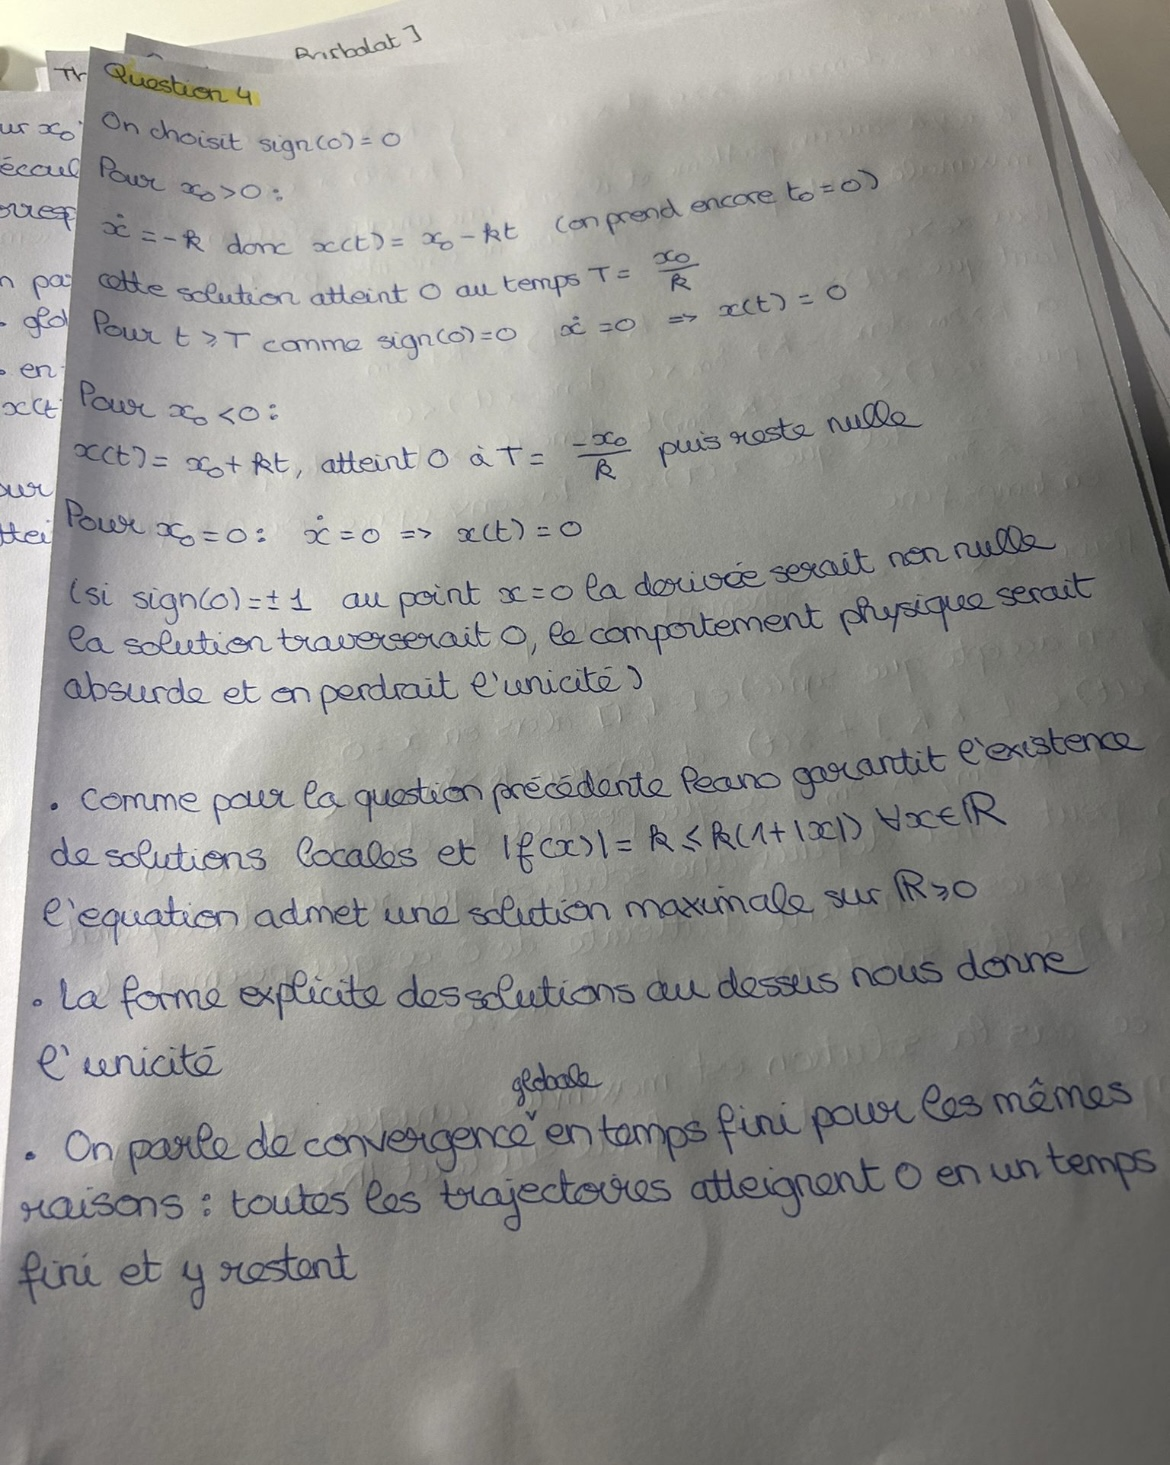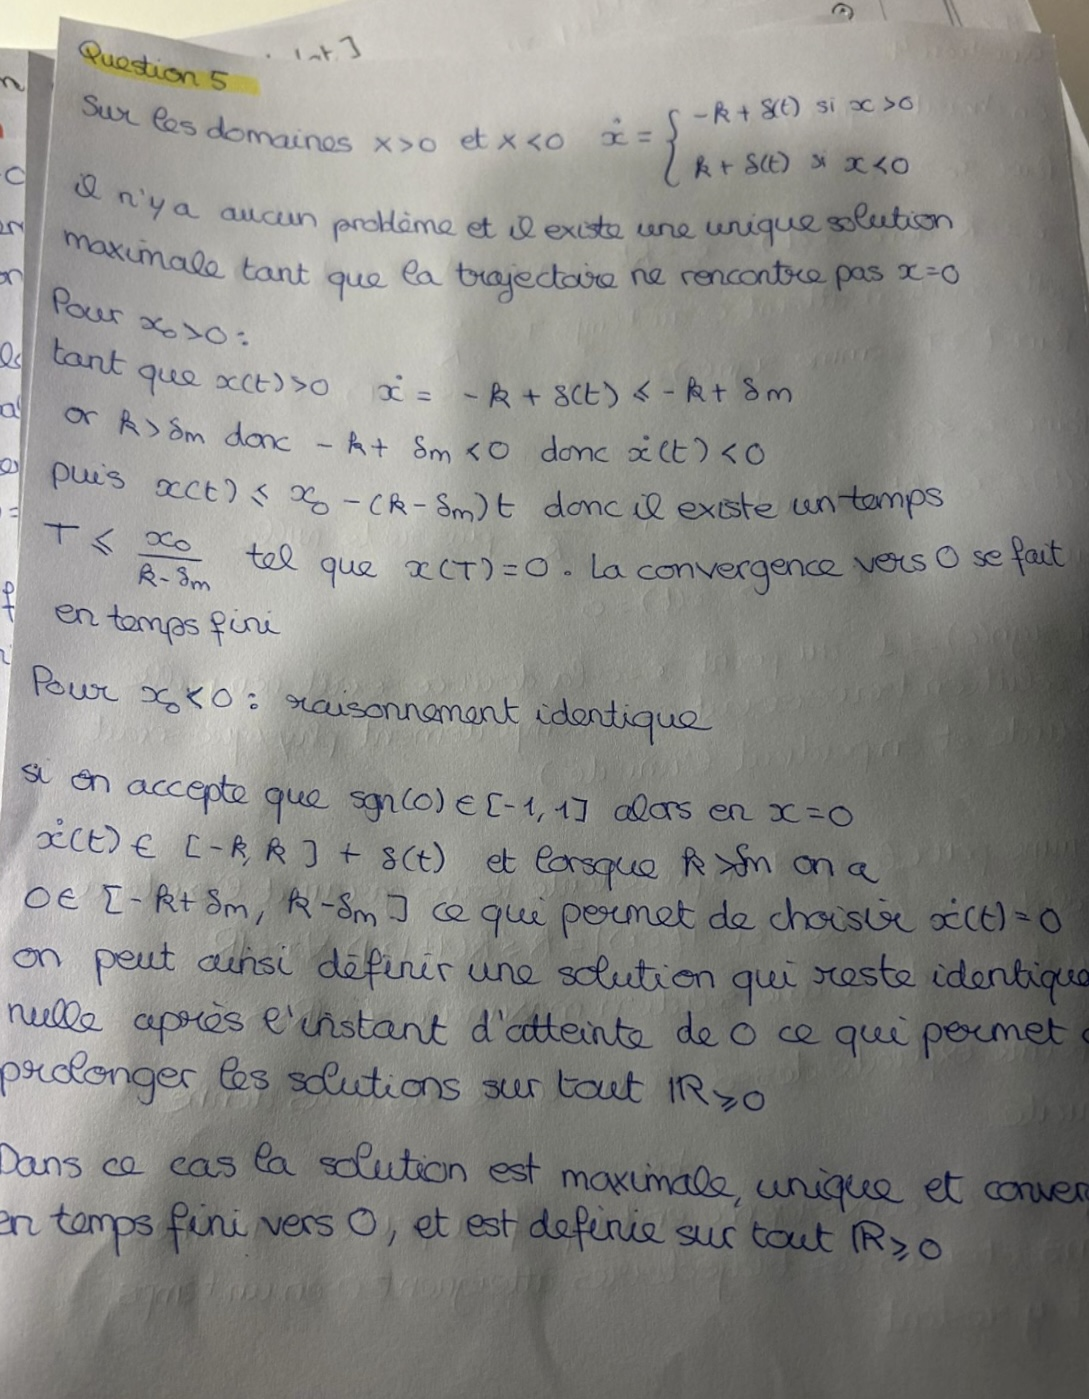

In [16]:
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def euler_perturbed(x0, k, delta_m, dt, tf):
    t = np.arange(0, tf+dt, dt)
    x = np.zeros(len(t))
    x[0] = x0

    for n in range(len(t)-1):
        delta = delta_m * (2*np.random.rand() - 1) 
        xdot = -k * sign(x[n]) + delta
        x[n+1] = x[n] + dt * xdot

        # blocage numérique en 0
        if abs(x[n+1]) < 1e-3:
            x[n+1:] = 0
            break

    return t, x

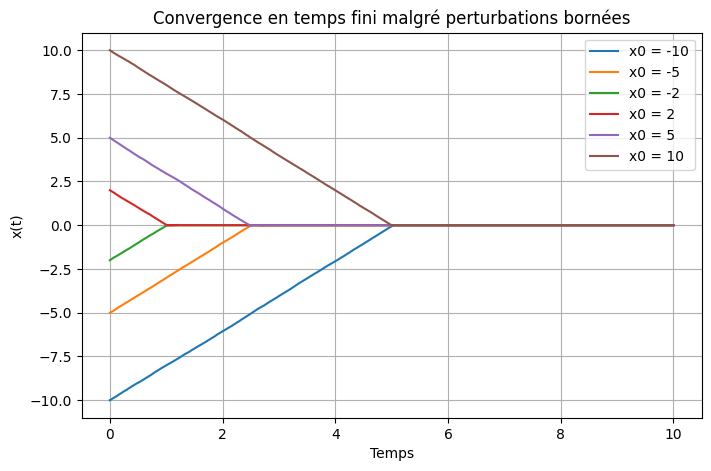

In [18]:
#paramètres
k = 2.0
delta_m = 0.5
dt = 0.01
tf = 10

CI = [-10, -5, -2, 2, 5, 10]

plt.figure(figsize=(8,5))

for x0 in CI:
    t, x = euler_perturbed(x0, k, delta_m, dt, tf)
    plt.plot(t, x, label=f"x0 = {x0}")


plt.xlabel("Temps")
plt.ylabel("x(t)")
plt.title("Convergence en temps fini malgré perturbations bornées")
plt.legend()
plt.grid()
plt.show()

**Question 7** Illustrer et commenter le comportement du schéma d'Euler explicite autour de 0. On parle de phénomène de chattering. Que se passe-t-il si $k$ est grand ? Proposer un schema d'Euler implicite pour ce système et montrer qu'il permet d'éviter ce *chattering* et d'assurer une convergence numérique exacte vers 0.


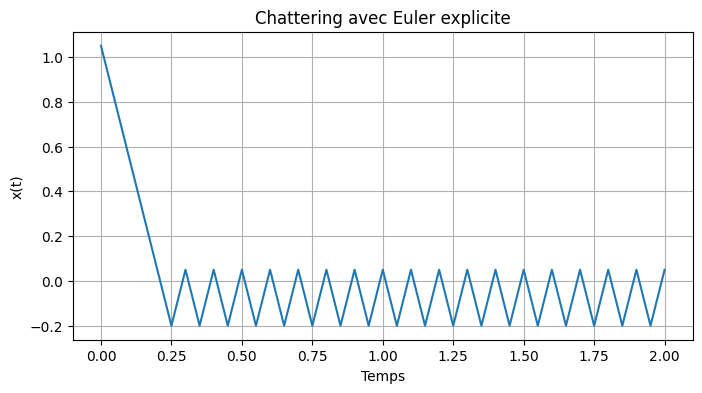

In [19]:
def euler_explicit_chattering(x0, t0, tf, dt, k):
    time = np.arange(t0, tf + dt, dt)
    sol = np.zeros(len(time))
    sol[0] = x0

    for n in range(len(time) - 1):
        sol[n+1] = sol[n] - k * dt * np.sign(sol[n])

    return time, sol


# Paramètres
k = 5       
dt = 0.05
t0 = 0.0
tf = 2.0
x0 = 1.05

# Simulation
time, sol = euler_explicit_chattering(x0, t0, tf, dt, k)

# Tracé
plt.figure(figsize=(8,4))
plt.plot(time, sol)
plt.xlabel("Temps")
plt.ylabel("x(t)")
plt.title("Chattering avec Euler explicite")
plt.grid()
plt.show()


La solution oscille autour de zero. Cela ne represente pas la réalité physique on souhaite donc l'éliminer.

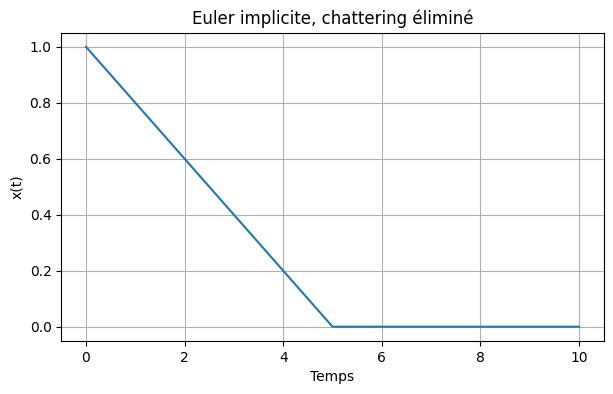

In [20]:
def euler_implicit_sliding(x0, t0, tf, dt):
    k = 0.2
    time = np.arange(t0, tf + dt, dt)
    sol = np.zeros(len(time))
    sol[0] = x0

    for n in range(len(time) - 1):
        if sol[n] > k * dt:
            sol[n+1] = sol[n] - k * dt
        elif sol[n] < -k * dt:
            sol[n+1] = sol[n] + k * dt
        else:
            sol[n+1] = 0.0

    return time, sol


# Test
x0 = 1.0
t0 = 0
tf = 10
dt = 0.01

time, sol = euler_implicit_sliding(x0, t0, tf, dt)


plt.plot(time, sol)
plt.xlabel("Temps")
plt.ylabel("x(t)")
plt.title("Euler implicite, chattering éliminé")
plt.grid()
plt.show()

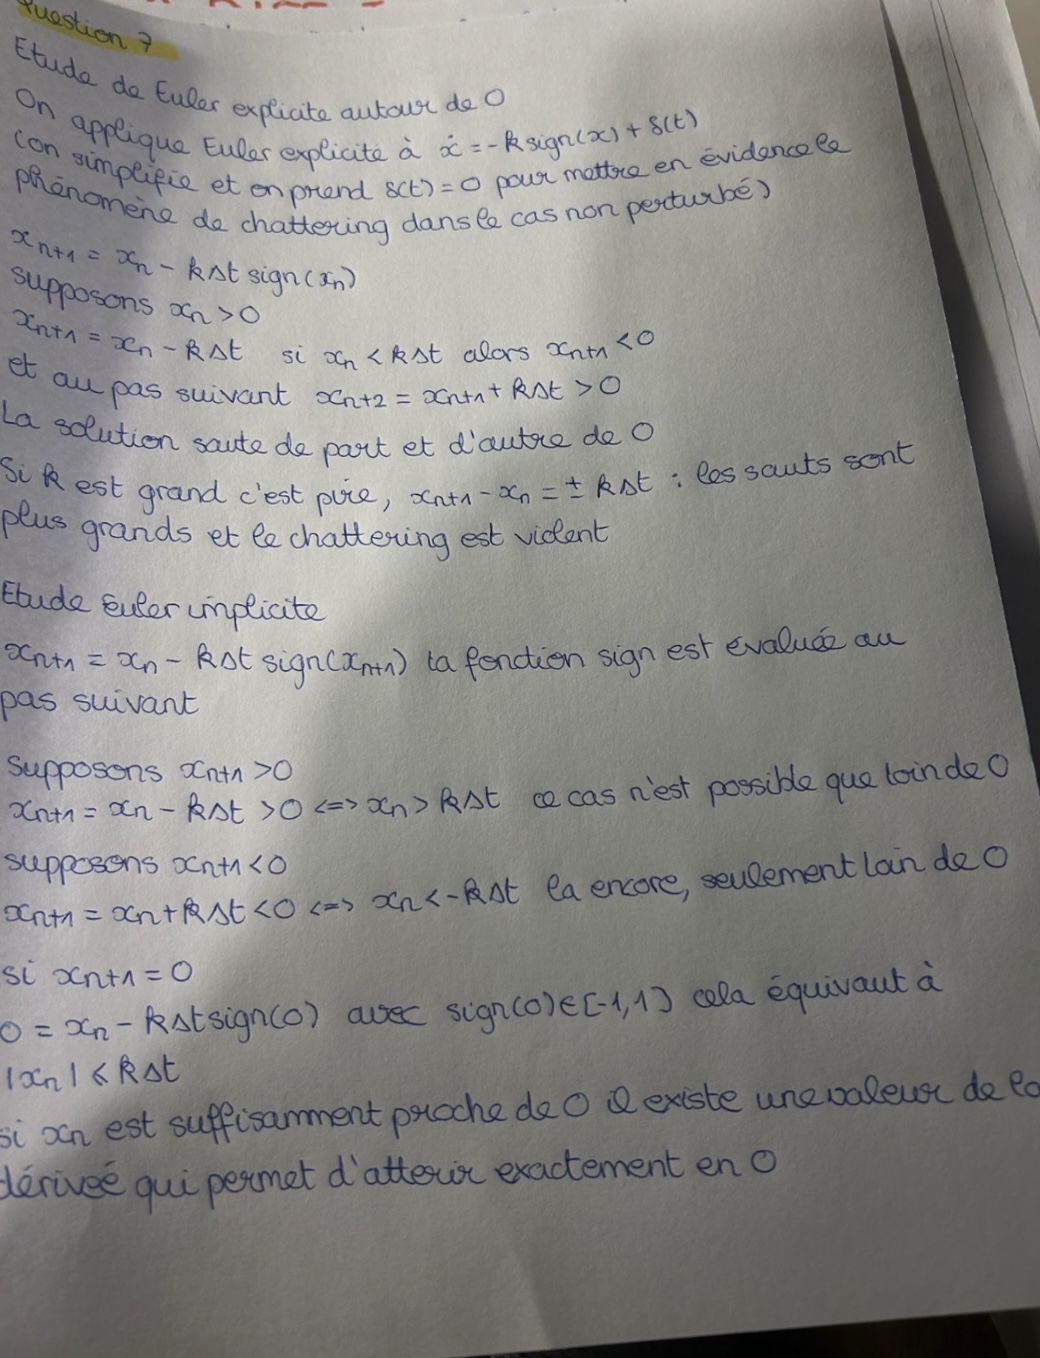

**Question 8** Application : donner un exemple physique d'un oscillateur évoluant selon
$$
\begin{array}{rcl}
\dot{x}_1 &=& x_2 \\
\dot{x}_2 &=& -x_1 - k {\rm sign}(x_2)  
\end{array}
$$
et proposer un schéma numérique pour simuler son comportement.

Ce système représente un oscillateur oscillant avec des frottements secs constants opposés à la vitesse. 
Par exemple une masse attachée à un ressort glissant sur une surface rugueuse avec frottement sec k.

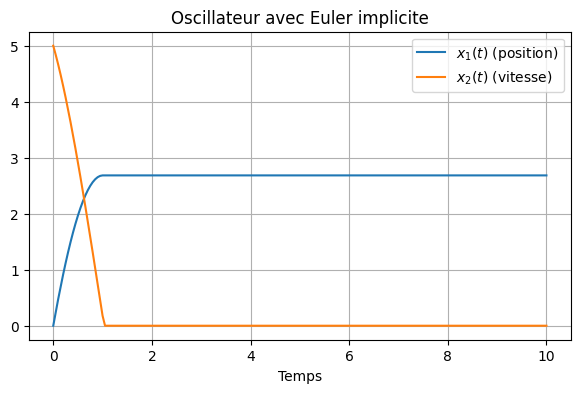

In [3]:
def euler_implicit_friction(x0, t0, tf, dt):
    time = np.arange(t0, tf + dt, dt)
    steps = len(time)
    x1 = np.zeros(steps)
    x2 = np.zeros(steps)
    x1[0], x2[0] = x0

    A = 1 + dt**2

    for n in range(steps - 1):
        y = x2[n] - dt * x1[n]

        if y > k * dt:
            x2[n+1] = (y - k * dt) / A
        elif y < -k * dt:
            x2[n+1] = (y + k * dt) / A
        else:
            x2[n+1] = 0.0  # collage

        x1[n+1] = x1[n] + dt * x2[n+1]

    return time, x1, x2


# Paramètres
k = 3
x0 = [0.0, 5.0]
t0, tf, dt = 0, 10, 0.05

t, x1, x2 = euler_implicit_friction(x0, t0, tf, dt)

# Affichage

plt.plot(t, x1, label=r"$x_1(t)$ (position)")
plt.plot(t, x2, label=r"$x_2(t)$ (vitesse)")
plt.title("Oscillateur avec Euler implicite")
plt.xlabel("Temps")
plt.legend()
plt.grid()
plt.show()